<a href="https://colab.research.google.com/github/pratik-poudel/datacrunch/blob/main/24th%20April%20converting%20to%20time%20series%20and%20predicting%20with%20MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [177]:
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import gc
# pd.options.display.float_format| = "{:.2f}".format
pd.options.display.max_columns = 500


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
import requests
from scipy import stats

import lightgbm as lgb

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [178]:
train_datalink_X = 'https://tournament.datacrunch.com/data/X_train.csv'  
train_datalink_y = 'https://tournament.datacrunch.com/data/y_train.csv'
hackathon_data_link = 'https://tournament.datacrunch.com/data/X_test.csv'

In [179]:
train = pd.read_csv(train_datalink_X)
target = pd.read_csv(train_datalink_y)
test = pd.read_csv(hackathon_data_link)

In [180]:
train.shape

(14687, 14)

In [181]:
train = pd.concat([train, target], axis=1)

In [182]:
train

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14,target_r,target_g,target_b
0,1.00,1.00,0.0,0.00,1.00,0.50,1.00,0.0,1.0,0.0,0.0,0.25,0.00,0.25,1.00,1.00,0.75
1,1.00,1.00,0.0,0.00,0.50,0.50,0.50,0.0,1.0,0.0,0.0,0.00,0.00,0.00,0.75,0.25,0.50
2,0.50,0.50,0.0,0.00,0.25,0.75,0.00,0.0,1.0,0.0,0.0,0.00,0.25,0.25,0.75,0.00,0.00
3,0.75,0.75,0.0,0.00,0.50,1.00,0.00,0.0,0.0,0.0,1.0,0.00,0.50,0.00,0.25,0.00,0.25
4,1.00,1.00,0.0,0.00,1.00,1.00,0.25,0.0,0.0,0.0,1.0,0.25,0.25,0.50,0.75,0.50,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14682,0.00,0.00,1.0,0.75,0.25,0.75,0.00,1.0,0.0,0.0,0.0,0.00,0.75,0.75,0.00,0.50,0.50
14683,0.25,0.25,1.0,0.75,0.25,0.75,0.25,1.0,0.0,0.0,0.0,0.00,0.75,0.75,0.00,0.50,0.50
14684,0.25,0.25,1.0,1.00,0.25,0.75,0.00,1.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.25,0.00
14685,0.00,0.00,1.0,0.75,0.00,0.75,0.00,1.0,0.0,0.0,0.0,0.00,0.75,0.75,0.00,0.50,0.50


In [183]:
# train = train.drop(['Moons', 'id'], axis=1)

In [184]:
train.shape[0] - (4687)

10000

In [185]:
validation_data = train[10000: ]
train_data = train[:10000]
train_data.shape

(10000, 17)

In [186]:
features = [f for f in train_data.columns if 'Feature' in f]
len(features)

14

# TRAINING

In [187]:
def scorer(y_test, y_pred):
    score = (stats.spearmanr(y_test, y_pred))[0]
    # print('Score as calculated for the leader board (っಠ‿ಠ)っ {}'.format(score))
    return score

In [188]:
# train[:10][['Feature_1', 'target_r']]

In [189]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()   
    for i in range(len(sequences)):
# find the end of this pattern
        end_ix = i + n_steps
# check if we are beyond the dataset
        if end_ix > len(sequences):
            break
# gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-3], sequences[end_ix-1, -3:]
        # print(seq_x.shape)
        # print(seq_y.shape)
        # print(seq_x, seq_y)
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)



In [190]:
train_data_arr = np.array(train_data)
validation_data_arr = np.array(validation_data)

In [191]:
train_data_arr.shape, validation_data_arr.shape

((10000, 17), (4687, 17))

In [192]:
%matplotlib inline
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

TIME STEPS : -------->  25
Epoch 00006: early stopping


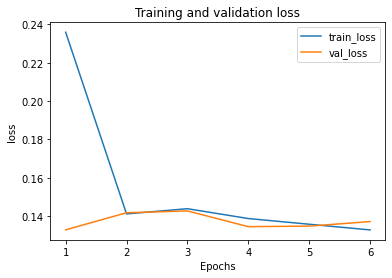

[25, 0.13185883882088154, 0.15509478196783563, 0.05443435477810744]
 
 
TIME STEPS : -------->  26
Epoch 00011: early stopping


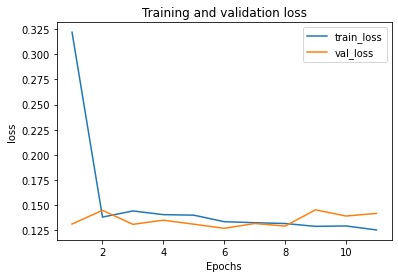

[26, 0.07417068504890321, 0.11326340736737912, 0.07360492772103]
 
 
TIME STEPS : -------->  27
Epoch 00007: early stopping


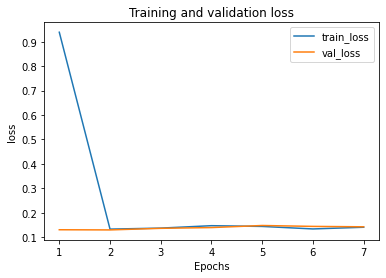

[27, 0.13469056169162386, 0.1796087754248259, 0.10404896010357056]
 
 
TIME STEPS : -------->  28
Epoch 00006: early stopping


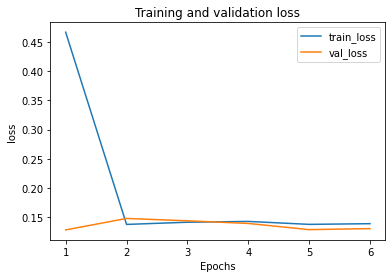

[28, 0.1463849788598309, 0.12314693505099661, 0.055856396220296804]
 
 
TIME STEPS : -------->  29
Epoch 00007: early stopping


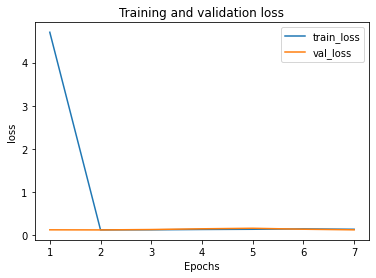

[29, 0.1290152044209378, 0.1510894797026271, 0.06646067209853551]
 
 
TIME STEPS : -------->  30
Epoch 00011: early stopping


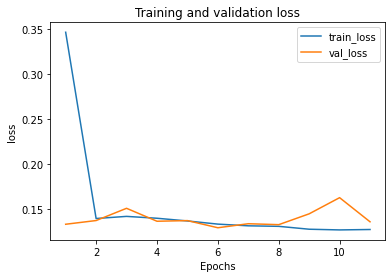

[30, 0.04472055080135236, 0.13415057192111896, 0.0877970304696407]
 
 
TIME STEPS : -------->  31
Epoch 00012: early stopping


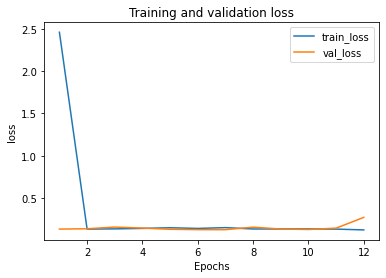

[31, 0.08351660184692451, 0.15401561509430162, 0.08236299401260144]
 
 
TIME STEPS : -------->  32
Epoch 00006: early stopping


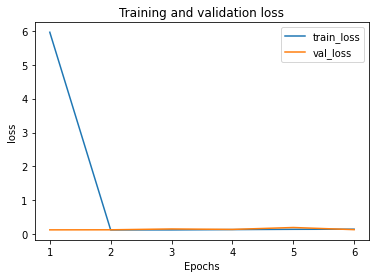

[32, 0.1393538230540189, 0.158278546646828, 0.07119025645948097]
 
 
TIME STEPS : -------->  33
Epoch 00013: early stopping


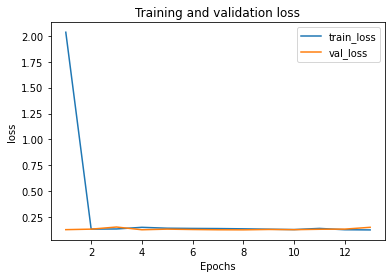

[33, 0.07162154124454434, 0.1523030713840658, 0.09695196374095529]
 
 
TIME STEPS : -------->  34
Epoch 00010: early stopping


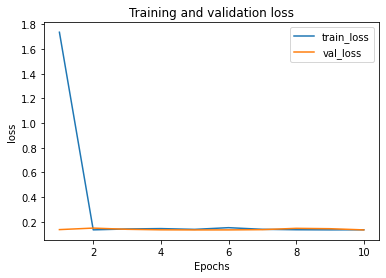

[34, 0.0835325508183001, 0.15097559314396708, 0.1114767890357234]
 
 
TIME STEPS : -------->  35
Epoch 00006: early stopping


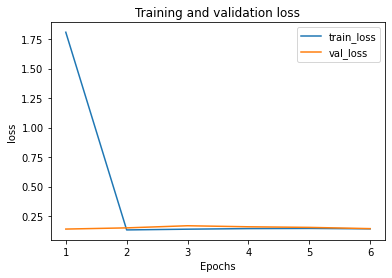

[35, 0.10333119769816966, 0.1358851696239634, 0.05685146642642584]
 
 


In [211]:
np.random.seed(60)
df = []
for i in range(25, 36):
    n_steps = i
    print( "TIME STEPS : --------> " , i)
    X_train, y_train = split_sequences(train_data_arr, n_steps)
    X_val, y_val = split_sequences(validation_data_arr, n_steps)

    n_input = X_train.shape[1] * X_train.shape[2]
    X_train = X_train.reshape((X_train.shape[0], n_input))
    X_val = X_val.reshape((X_val.shape[0], n_input))

    from keras.models import Sequential
    from keras.layers import Dense

    # model = Sequential()
    # model.add(Dense(1024, activation='sigmoid', input_dim=n_input))
    # model.add(Dense(512, activation='relu'))
    # model.add(Dense(150, activation='relu'))
    # model.add(Dense(3))
    # model.compile(optimizer='rmsprop', loss='mse')


    model = Sequential()
    model.add(Dense(1024, activation='relu', input_dim=n_input))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(150, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(3))
    model.compile(optimizer='rmsprop', loss='mse')


    early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    mcp_save = ModelCheckpoint('./model.hdf5', save_best_only=True, monitor='val_loss', mode='min')

    batch_size = 512
    epochs = 250

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,verbose=None, validation_data=(X_val, y_val), 
                        callbacks=[early_stopping, mcp_save], shuffle=False)

    
    plot_metric(history, 'loss')
    plt.show()

    model.load_weights('model.hdf5')
    preds= model.predict(X_val, batch_size=batch_size)
    cols = ['target_r', 'target_g', 'target_b']
    preds = pd.DataFrame(preds, columns=cols)

    scores = []
    scores.append(n_steps)
    scores.append(scorer(y_val[:, 0], preds.target_r))
    scores.append(scorer(y_val[:, 1], preds.target_g))
    scores.append(scorer(y_val[:, 2], preds.target_b))
    df.append(pd.DataFrame(scores))
    print(scores)
    print(" ")
    print(" ")


In [141]:
# df

In [212]:
df = pd.concat(df, axis=1)
df.columns = df.iloc[0]
df.drop(df.index[0], inplace=True)

In [213]:
df.T

,1,2,3
0,,,
25.0,0.131859,0.155095,0.054434
26.0,0.074171,0.113263,0.073605
27.0,0.134691,0.179609,0.104049
28.0,0.146385,0.123147,0.055856
29.0,0.129015,0.151089,0.066461
30.0,0.044721,0.134151,0.087797
31.0,0.083517,0.154016,0.082363
32.0,0.139354,0.158279,0.071190
33.0,0.071622,0.152303,0.096952


In [216]:
df.T.mean(axis=1)

0
25.0    0.113796
26.0    0.087013
27.0    0.139449
28.0    0.108463
29.0    0.115522
30.0    0.088889
31.0    0.106632
32.0    0.122941
33.0    0.106959
34.0    0.115328
35.0    0.098689
dtype: float64

# NEW

In [237]:
train = pd.read_csv(train_datalink_X)
target = pd.read_csv(train_datalink_y)
test = pd.read_csv(hackathon_data_link)

In [238]:
train = pd.concat([train, target], axis=1)
# train = train.drop(['id', 'Moons'], axis=1)

In [239]:
train.shape

(14687, 17)

In [240]:
features = [f for f in train_data.columns if 'Feature' in f]
len(features)

14

In [241]:
validation_data = train[10000: ]
train_data = train[:10000]

In [242]:
validation_data.shape[0] - 27

4660

In [243]:
test_merge = validation_data[4661:]
test_merge.shape

(26, 17)

In [244]:
test.shape

(12910, 14)

In [245]:
cols = ['target_r', 'target_g', 'target_b']
test_merge.drop(columns=cols, inplace=True)

In [246]:
validation_data = validation_data[:4661]
validation_data.shape

(4661, 17)

In [247]:
train_data_arr = np.array(train_data)
validation_data_arr = np.array(validation_data)
validation_data_arr.shape

(4661, 17)

(9974, 27, 14)
(4635, 27, 14)
Epoch 00013: early stopping


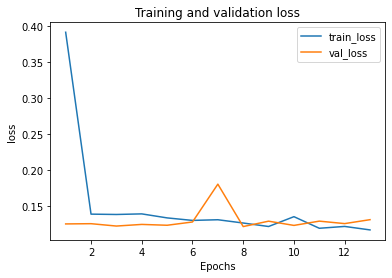

0.13276319529623481
0.1648863402091131
0.12129721195013018


In [249]:
np.random.seed(60)
n_steps = 27
X_train, y_train = split_sequences(train_data_arr, n_steps)
print(X_train.shape)
X_val, y_val = split_sequences(validation_data_arr, n_steps)
print(X_val.shape)
n_input = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape((X_train.shape[0], n_input))
X_val = X_val.reshape((X_val.shape[0], n_input))

from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(1024, activation='relu', input_dim=n_input))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(150, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(3))
model.compile(optimizer='rmsprop', loss='mse')


early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mcp_save = ModelCheckpoint('./model.hdf5', save_best_only=True, monitor='val_loss', mode='min')

batch_size = 512
epochs = 250



history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,verbose=0, validation_data=(X_val, y_val), 
                    callbacks=[early_stopping, mcp_save], shuffle=True)


plot_metric(history, 'loss')

model.load_weights('model.hdf5')
preds= model.predict(X_val, batch_size=batch_size)
cols = ['target_r', 'target_g', 'target_b']
preds = pd.DataFrame(preds, columns=cols)

print(scorer(y_val[:, 0], preds.target_r))
print(scorer(y_val[:, 1], preds.target_g))
print(scorer(y_val[:, 2], preds.target_b))

In [250]:
X_val.shape

(4635, 378)

In [251]:
test_data_with_lag = pd.concat([test_merge, test])
test_data_with_lag.shape

(12936, 14)

In [252]:
test.shape[0]

12910

In [253]:
def split_sequences_for_prediction(sequences, n_steps):
    X= list()   
    for i in range(len(sequences)):
# find the end of this pattern
        end_ix = i + n_steps
# check if we are beyond the dataset
        if end_ix > len(sequences):
            break
# gather input and output parts of the pattern
        seq_x =sequences[i:end_ix]
        # print(seq_x)
        X.append(seq_x)
    return np.array(X)

In [258]:
preds_data = split_sequences_for_prediction(np.array(test_data_with_lag[features]), 27)

In [259]:
preds_data.shape

(12910, 27, 14)

In [261]:
n_input

378

In [262]:
preds_data = preds_data.reshape((preds_data.shape[0], n_input))
preds_data.shape

(12910, 378)

In [263]:
prediction = pd.DataFrame(model.predict(preds_data, batch_size=batch_size))

In [264]:
prediction.columns = cols

In [265]:
prediction

,target_r,target_g,target_b
0,0.457331,0.747547,0.662309
1,0.450825,0.595892,0.553577
2,0.503388,0.633838,0.573107
3,0.450464,0.600305,0.568969
4,0.454152,0.647030,0.587874
...,...,...,...
12905,0.474860,0.509798,0.497627
12906,0.559444,0.583312,0.554144
12907,0.524076,0.579744,0.554501
12908,0.499168,0.648788,0.597388


In [266]:
test.shape, prediction.shape

((12910, 14), (12910, 3))

# Predictions

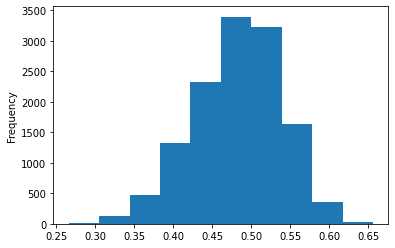

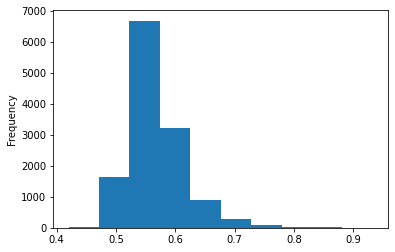

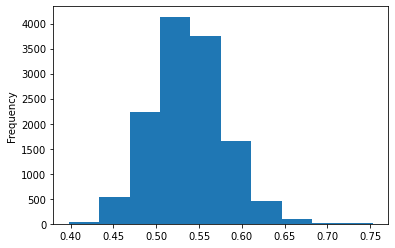

In [267]:
prediction['target_r'].plot(kind='hist')
plt.show()
prediction['target_g'].plot(kind='hist')
plt.show()
prediction['target_b'].plot(kind='hist')
plt.show()

In [268]:
API_KEY = "0GIskIC9Rd1I8sMw6nStutbIbMx7AaZzAyNfuMOVAVWgJtNa1IVQHZAD3WPj" # <- HERE

r = requests.post("https://tournament.datacrunch.com/api/submission",
    files = {
        "file": ("x", prediction.to_csv().encode('ascii'))
    },
    data = {
        "apiKey": API_KEY
    },
)

if r.status_code == 200:
    print("Submission submitted :)")
elif r.status_code == 423:
    print("ERR: Submissions are close")
    print("You can only submit during rounds eg: Friday 7pm GMT+1 to Sunday midnight GMT+1.")
    print("Or the server is currently crunching the submitted files, please wait some time before retrying.")
elif r.status_code == 422:
    print("ERR: API Key is missing or empty")
    print("Did you forget to fill the API_KEY variable?")
elif r.status_code == 404:
    print("ERR: Unknown API Key")
    print("You should check that the provided API key is valid and is the same as the one you've received by email.")
elif r.status_code == 400:
    print("ERR: The file must not be empty")
    print("You have send a empty file.")
elif r.status_code == 401:
    print("ERR: Your email hasn't been verified")
    print("Please verify your email or contact a cruncher.")
elif r.status_code == 429:
    print("ERR: Too many submissions")
else:
    print("ERR: Server returned: " + str(r.status_code))
    print("Ouch! It seems that we were not expecting this kind of result from the server, if the probleme persist, contact a cruncher.")

Submission submitted :)
